실습대상 데이터 파일 연결 - 구글 드라이브  
파일명 kospi.csv

# Chapter 3. Deep learning Practice (2)
### 문제: Vanila RNN을 이용한 Kospi 예측

### 데이터 설명
- Date: 날짜
- Close: 종가 (종료시 가격)
- Open : 시가 (시작시 가격)
- High: 고가 (가장 높은 가격)
- Low: 저가 (가장 낮은 가격)
- Volume: 거래량 (매매된 주식 수, 주)


(Torch 기반)

In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt


In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'{device} is available')

cuda:0 is available


In [2]:
s = 'https://raw.githubusercontent.com/jongmoonha/AI-ME-Practice/refs/heads/main/data/kospi.csv'
df = pd.read_csv(s) # volumn: 생산량
print(df.shape)
df.head(3)

(431, 7)


,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-30,2183.489990,2206.199951,2177.879883,2206.199951,2206.199951,480400
1,2019-01-31,2222.879883,2222.879883,2201.219971,2204.850098,2204.850098,545200
2,2019-02-01,2211.929932,2218.780029,2201.409912,2203.459961,2203.459961,479400


## 기본전처리만 수행 (0~1 scaling)
- 입력변수: ['Open','High','Low','Volume']
- 종속변수: ['Close']

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df[['Open','High','Low','Close','Volume']] = scaler.fit_transform(df[['Open','High','Low','Close','Volume']])
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-30,0.722898,0.732351,0.745525,0.759235,2206.199951,0.242113
1,2019-01-31,0.763058,0.750069,0.769089,0.757866,2204.850098,0.274771
2,2019-02-01,0.751894,0.745714,0.769280,0.756456,2203.459961,0.241609
3,2019-02-07,0.755809,0.742538,0.764596,0.756415,2203.419922,0.215603
4,2019-02-08,0.731584,0.717777,0.739548,0.729669,2177.050049,0.197057


In [ ]:
X = df[['Open','High','Low','Volume']].values
y = df['Close'].values

In [ ]:
X.shape

(431, 4)

In [ ]:
def seq_data(x, y, sequence_length):
  '''
  x는 sequence_length 만큼의 데이터를 가진다.
  y는 sequence_length+1번째 값을 예측한다
  (x,y) 구조를 만든다.
  '''
  x_seq = []
  y_seq = []
  for i in range(len(x) - sequence_length):
    x_seq.append(x[i: i+sequence_length])
    y_seq.append(y[i+sequence_length])

  return torch.FloatTensor(x_seq).to(device), torch.FloatTensor(y_seq).to(device).view([-1, 1]) # float형 tensor로 변형, gpu사용가능하게 .to(device)를 사용.

In [ ]:
sequence_length = 5 # 5일치 단위로 자른다
x_seq, y_seq = seq_data(X, y, sequence_length)
x_seq.shape # [(X.shape[0]-sequence_length), sequence_length, X_col]

<ipython-input-9-2ebc2ecb4810>:13: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.FloatTensor(x_seq).to(device), torch.FloatTensor(y_seq).to(device).view([-1, 1]) # float형 tensor로 변형, gpu사용가능하게 .to(device)를 사용.


torch.Size([426, 5, 4])

In [ ]:
split = 200  # train에 사용할 데이터 (이후는 Test)
x_train_seq = x_seq[:split]
y_train_seq = y_seq[:split]
x_test_seq = x_seq[split:]
y_test_seq = y_seq[split:]
print(x_train_seq.size(), y_train_seq.size())
print(x_test_seq.size(), y_test_seq.size())



torch.Size([200, 5, 4]) torch.Size([200, 1])
torch.Size([226, 5, 4]) torch.Size([226, 1])


In [ ]:
train = torch.utils.data.TensorDataset(x_train_seq, y_train_seq)
test = torch.utils.data.TensorDataset(x_test_seq, y_test_seq)

batch_size = 20 # mini-batch
train_loader = torch.utils.data.DataLoader(dataset=train, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test, batch_size=batch_size, shuffle=False)

In [ ]:
input_size = x_seq.size(2)
# 모델 구조(layer 개수, layer별 hidden state 노드 크기)
num_layers = 2
hidden_size = 8

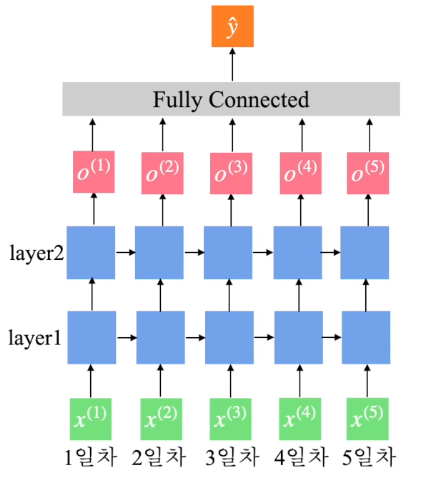

# Model Define

In [ ]:
class VanillaRNN(nn.Module):

  def __init__(self, input_size, hidden_size, sequence_length, num_layers, device):
    super(VanillaRNN, self).__init__()
    self.device = device
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
    
    '''
    Many to Many 전략에서는, Sequence Length 만큼의 hidden state를 모두 사용한다.
    Many to One 전략에서는, Sequence Length 만큼의 hidden state를 모두 사용하지 않고, 마지막 hidden state만 사용한다.
    '''
    self.fc = nn.Sequential(nn.Linear(hidden_size * sequence_length, 1), nn.Sigmoid()) # many to many 전략

  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device) # 초기 hidden state 설정하기.
    out, _ = self.rnn(x, h0) # out: RNN의 마지막 레이어로부터 나온 output feature 를 반환한다. hn: hidden state를 반환한다.
    out = out.reshape(out.shape[0], -1) # many to many 전략
    out = self.fc(out) # 각 날짜마다 나오는 output과 hidden state를 합쳐서 일렬로 펴서 binary 계산한다. (sequence_length * hidden_size) - (단위시퀀스(윈도우) * hidden size)
    return out

In [ ]:
model = VanillaRNN(input_size=input_size,
                   hidden_size=hidden_size,
                   sequence_length=sequence_length,
                   num_layers=num_layers,
                   device=device).to(device)

## RNN 하이퍼 파라미터 설정

In [ ]:
criterion = nn.MSELoss()

lr = 1e-3
num_epochs = 200
optimizer = optim.Adam(model.parameters(), lr=lr)

In [ ]:
loss_graph = [] # 그래프용 loss.
n = len(train_loader)

for epoch in range(num_epochs):
  running_loss = 0.0

  for data in train_loader:

    seq, target = data # 배치 데이터.
    out = model(seq)   # 모델에 넣고,
    loss = criterion(out, target) # output 가지고 loss 구하고,

    optimizer.zero_grad() #
    loss.backward() # loss가 최소가 되게하는
    optimizer.step() # 가중치 업데이트 해주고,
    running_loss += loss.item() # 한 배치의 loss 더해주고,

  loss_graph.append(running_loss / n) # 한 epoch에 모든 배치들에 대한 평균 loss 리스트에 담고,
  if epoch % 100 == 0:
    print('[epoch: %d] loss: %.4f'%(epoch, running_loss/n))

[epoch: 0] loss: 0.0305
[epoch: 100] loss: 0.0010


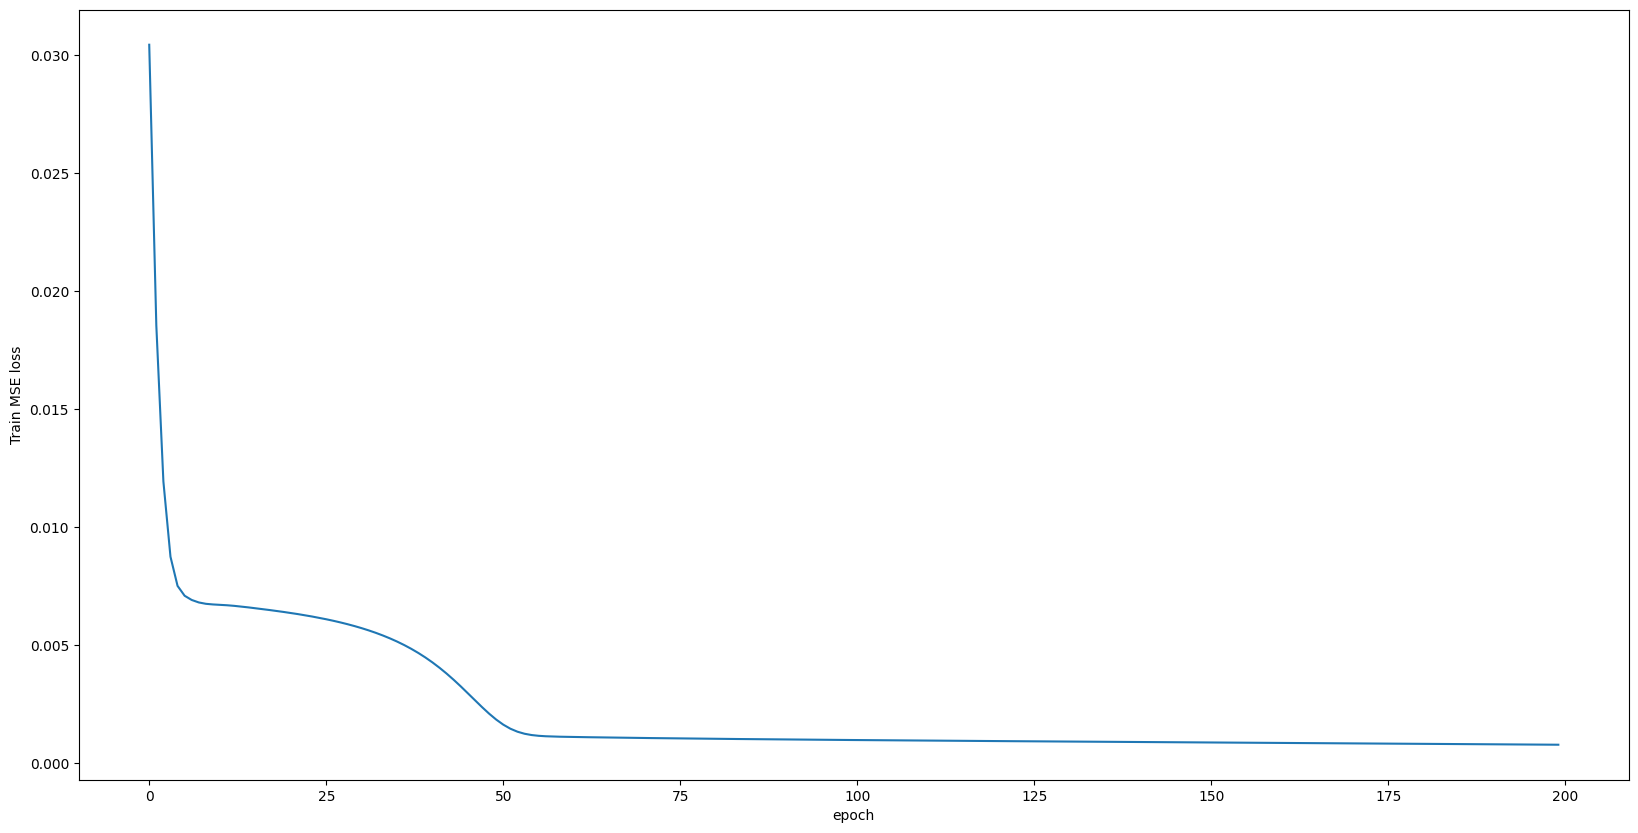

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(loss_graph)
plt.xlabel('epoch')
plt.ylabel('Train MSE loss')
plt.show()

# Predict Target Function

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
def plotting(train_loader, test_loader, actual):
  with torch.no_grad():
    train_pred = []
    test_pred = []

    for data in train_loader:
      seq, target = data
      out = model(seq)
      train_pred += out.cpu().numpy().tolist()
    train_mse=mean_squared_error(list(actual[:len(train_pred)]),train_pred)
    for data in test_loader:
      seq, target = data
      out = model(seq)
      test_pred += out.cpu().numpy().tolist()
    test_mse=mean_squared_error(list(actual[len(train_pred):]),test_pred)

  total = train_pred + test_pred
  plt.figure(figsize=(20,10))
  plt.plot(np.ones(100)*len(train_pred), np.linspace(0,1,100), '--', linewidth=0.6)
  plt.plot(actual, '--')
  plt.plot(total, 'b', linewidth=0.6)

  plt.legend(['train boundary', 'actual', 'prediction'])
  plt.title('Predict Stock with RNN: train rmse {:.5f}, test rmse{:.5f}'.format(train_mse, test_mse))
  plt.show()
  return train_pred, test_pred, train_mse, test_mse

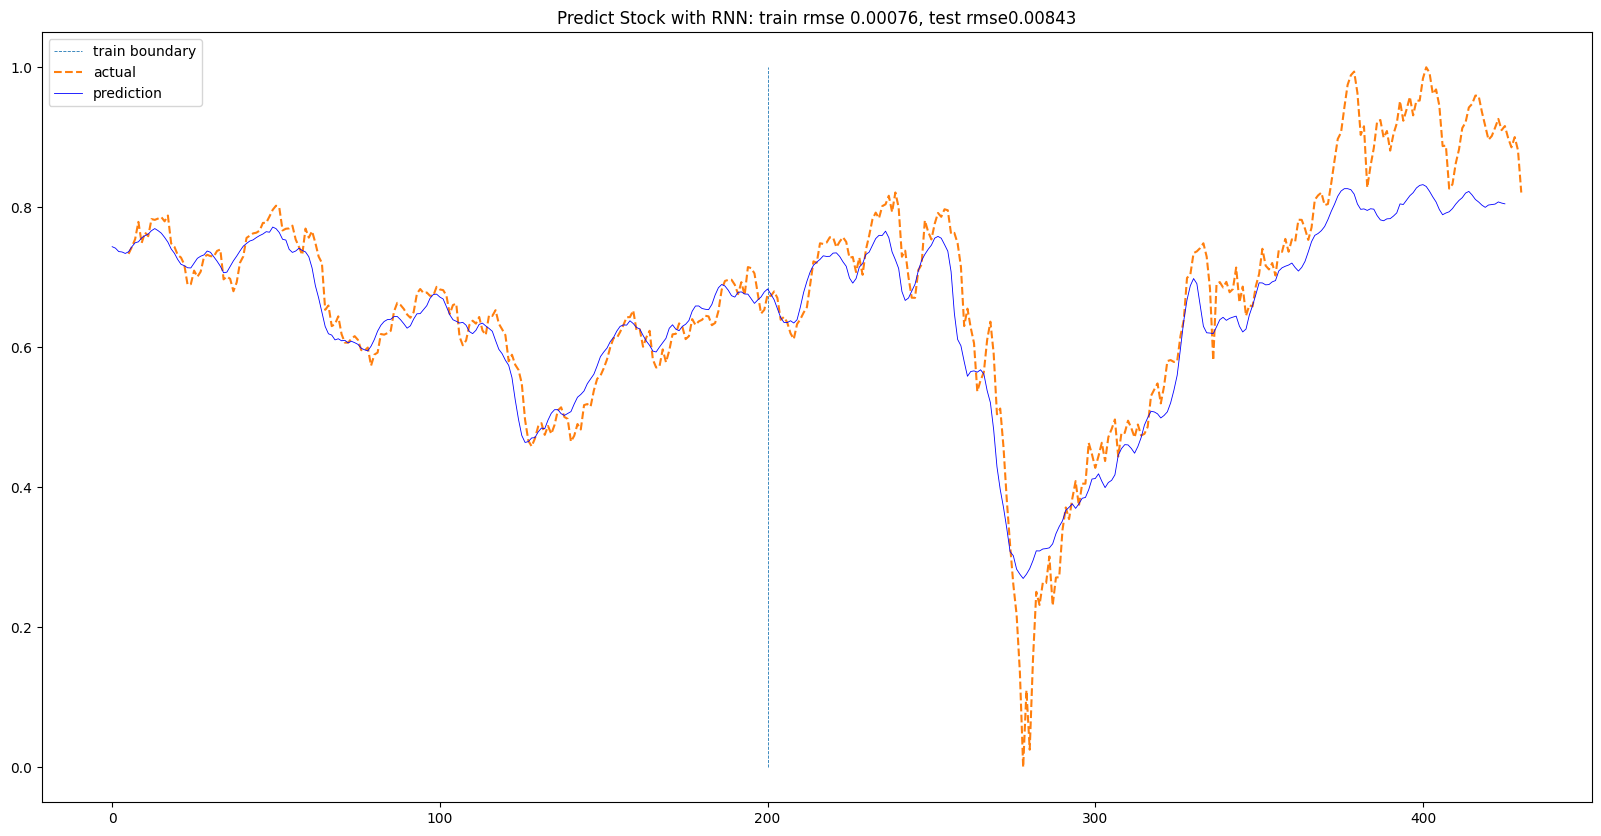

In [ ]:
train_pred, test_pred, train_mse, test_mse=plotting(train_loader, test_loader, df['Close'][sequence_length:])

In [ ]:
train_mse

0.000757214940614713

In [ ]:
test_mse

0.008433519504836678